In [ ]:
import sys
sys.path.append('../')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
#import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score

## Load Data
Load all your data into two variables "x" and "y". The variable "x" should contain information on the features (e.g., concentrations of reagents) that are to be investigated and the variable "y" should contain the outcome (e.g., peak spectra position). The variables "x" and "y" should have the same number of rows.  

In [2]:
data = pd.read_excel('../SAXS Structural Exploration/SAXS/Volumes_and_Structure.xlsx')
data.fillna(0, inplace=True)
data = data.values
PVP = (data[:,2]*2/325).reshape(-1,1)
TA = (data[:,4]*2/325).reshape(-1,1)
AA = (data[:,5]*2/325).reshape(-1,1)
SN = (data[:,6]*2/325).reshape(-1,1)
Seeds = (data[:,7]*0.025/325).reshape(-1,1) #Use mM as units 
x = np.hstack((PVP, TA, AA, SN, Seeds))
X = x.copy() 
thickness = (data[:,8]).reshape(-1,1)
radius = (data[:,9]).reshape(-1,1)
P_radius_PD = (data[:,10]).reshape(-1,1)
p_scale = (data[:,12]).reshape(-1,1)
s_radius = (data[:,12]).reshape(-1,1)
peak_wv = (data[:,13]).reshape(-1,1)

y = np.hstack((thickness, radius, s_radius))
Y = y.copy()
t = thickness
r = radius
c = s_radius

In [3]:
#Find locations of samples that were fit with the monodisperse plate model 
label = []
for i in range(x.shape[0]):
    if s_radius[i] == 0:
        label.append(0) #monodisperse plate
    elif s_radius[i] > 0 and P_radius_PD[i] > 0:
        label.append(2) #plates and sphere polydisperse
    else:
        label.append(1) # plates and sphere
label_a = np.array(label)
#x = x[np.where(label_a == 0)[0]]
#y = y[np.where(label_a == 0)[0]]

In [4]:
y = label_a.reshape(-1,1)

## Normalize Data
Next we will normalize all the data points so that they have mean 0 and variance 1

In [5]:
scaler = MinMaxScaler()
x = scaler.fit(x).transform(x)

In [6]:
scaler = MinMaxScaler()
y = scaler.fit(y).transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                            test_size=0.25,
                                            random_state=7)

## Regressor 
The regressor is used to train the machine learning model so it can predict "y" from values of "x"

In [8]:
rbf = ConstantKernel(1.0) * RBF(length_scale=.1)
gpc = GaussianProcessRegressor(kernel=rbf)
model = gpc.fit(X_train, y_train.ravel())

## SHAP plots
This section will be used to make the SHAP plots. In the next code cell, create a list with the names of all the reagents. 

Using 102 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.05it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


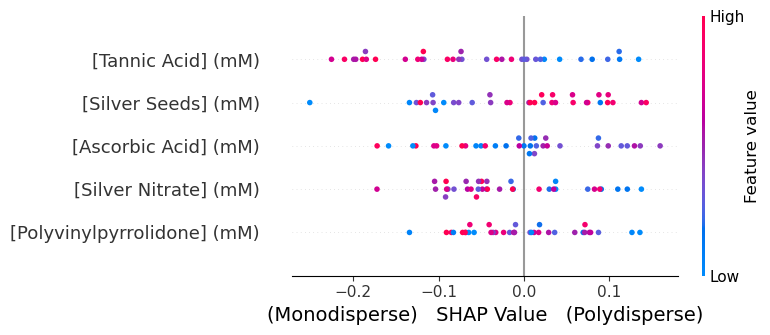

In [9]:
plt.rcParams.update({'font.size': 12})
X_test = pd.DataFrame(X_test, columns = ['[Polyvinylpyrrolidone] (mM)', '[Tannic Acid] (mM)', '[Ascorbic Acid] (mM)', '[Silver Nitrate] (mM)', '[Silver Seeds] (mM)'])
# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=False)
ax.set_xlabel("(Monodisperse)   SHAP Value   (Polydisperse)", fontsize=14)
#plt.savefig('../../Figures/230214/Shap_Plate_Thickness.png')
plt.show()

Text(0.5, 24.722222222222214, 'SHAP value')

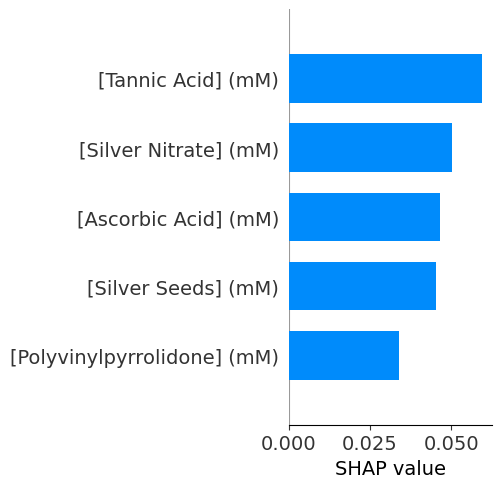

In [20]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, plot_size=[5,5])
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value", fontsize=14)
#plt.savefig('../../Figures/SHAP_Agg_vs_all_bar.png')